<a href="https://colab.research.google.com/github/PetrovAlexey/GenerativeModels/blob/main/homework_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1. PixelCNN

During this homework, you will train PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling with class conditioning.

- Task 1 (10 points): PixelCNN on binary MNIST
- **Task 2 (10 points): Conditional PixelCNN**
- \* Bonus (10+++ points)

## Task 2. Conditional PixelCNNs on Shapes and MNIST

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise). You may need `nn.Embedding` here

You can use a PixelCNN architecture similar to Task 1. Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes

Feel free to use and modify any sources from Task 1

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import math
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

In [ ]:
import pickle
from torchvision.utils import make_grid

def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()
        

def load_data(fname, binarize=True, include_labels=False):
    with open(fname, 'rb') as data_file:
        data = pickle.load(data_file)
    
    if include_labels:
        return (data['train'] > 127.5), (data['test'] > 127.5), data['train_labels'], data['test_labels']
    
    return (data['train'] > 127.5), (data['test'] > 127.5)


class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        
        assert len(X) == len(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
# For colab users: download data
!wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl
!wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/mnist.pkl

--2021-05-08 11:54:20--  https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/shapes.pkl [following]
--2021-05-08 11:54:20--  https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/shapes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6108167 (5.8M) [application/octet-stream]
Saving to: ‘shapes.pkl.5’

shapes.pkl.5        100%[===================>]   5.83M  --.-KB/s    in 0.05s   

2021-05-08 11:54:20 (110 MB/s) - ‘shapes.pkl.5’ 

In [ ]:
class MaskedConv2D(nn.Conv2d):
    def __init__(self, mask_type, n_classes=4, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.ones(self.weight.data.size()))
        self.create_mask(mask_type)
        self.out_channels = kwargs["out_channels"]
        self.emb = nn.Embedding(n_classes, self.out_channels)
    
    def forward(self, x):
        """
        x: (N, C_in, H_in, W_in) torch.Tensor
        Returns
          - out (N, C_out, H_out, W_out) should be conv2d(x, weight * mask) + bias 
        """
        padding = max(self.kernel_size[0] // 2, 0)
        self.padding = padding
        self.weight.data *= self.mask
        return super().forward(x[0]) + self.emb(x[1]).view(x[0].shape[0], self.out_channels, 1, 1) , x[1]
    
    def create_mask(self, mask_type):
        assert mask_type == 'A' or mask_type == 'B'
        k = self.kernel_size[0]
        y, x = self.mask.size(2) // 2, self.mask.size(3) // 2
        self.mask[:, :, y + 1:, :].zero_()
        self.mask[:, :, y:, (mask_type == 'A' and x or x + 1):].zero_()

In [ ]:
class PixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors=2, n_filters=64,
               kernel_size=7, n_layers=5, labels=4):
        super().__init__()
        assert n_layers >= 2
        n_channels = input_shape[0]
        self.n_layers = n_layers
        self.input_shape = input_shape
        self.n_channels = n_channels
        self.n_colors = n_colors
        self.labels = 4

        for r in range(1, n_layers + 1):
            self.add_module('layer' + str(r), MaskedConv2D('B', labels, n_filters, kernel_size=kernel_size, out_channels=n_filters, padding=1))

        self.conv1 = MaskedConv2D('A', labels, n_channels, kernel_size=kernel_size, out_channels=n_filters, padding=1)        
        self.conv7 = MaskedConv2D('B', labels, n_filters, kernel_size=1, out_channels=n_filters, padding=1)
        self.conv8 = MaskedConv2D('B', labels, n_filters, kernel_size=1, out_channels=n_filters, padding=1)
        self.conv9 = MaskedConv2D('B', labels, n_filters, kernel_size=1, out_channels=1, padding=1)
        
    def forward(self, x, cond=None):
        batch_size = x[0].shape[0]
        x = x[0].cuda(), x[1].cuda()
        x = ((x[0].float() / (self.n_colors - 1) - 0.5) / 0.5, x[1])
        x = self.conv1(x)
        x = nn.functional.relu(x[0]), x[1]

        for r in range(1, self.n_layers + 1):
            x = getattr(self, 'layer' + str(r))(x)
            x = nn.functional.relu(x[0]), x[1]

        x = self.conv7(x)
        x = nn.functional.relu(x[0]), x[1]
        x = self.conv8(x)
        x = nn.functional.relu(x[0]), x[1]
        x = self.conv9(x)
        x = nn.functional.sigmoid(x[0])
        return x

    def loss(self, x):
        return F.binary_cross_entropy(torch.flatten(self.forward(x)).cuda(), x[0].float().view(-1).cuda())

    def sample(self, n, labels):
        samples = torch.zeros(n, *self.input_shape).cuda()
        label = labels
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.n_channels):
                        logits = self.forward((samples, label))[:, k, r, c]
                        probs = torch.tensor(logits)
                        samples[:, k, r, c] = torch.bernoulli(probs).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [ ]:
def train(model, train_loader, optimiser):
    model.train()
    train_losses = []
    for i, (a, b) in enumerate(train_loader):
        x = torch.tensor(a).permute(0, 3, 1, 2).cuda(), torch.tensor(b).cuda()
        optimiser.zero_grad()
        loss = model.loss(x)
        loss.backward()
        optimiser.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (a, b) in enumerate(data_loader):
            x = torch.tensor(a).permute(0, 3, 1, 2).cuda(), torch.tensor(b).cuda()
            #x = x.cuda()
            #x = x.float()
            loss = model.loss(x)
            total_loss += loss * x[0].shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        print(f'epoch {epoch} started')
        model.train()
        train_losses.extend(train(model, train_loader, optimizer))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print('train loss: {}, test_loss: {}'.format(np.mean(train_losses[-1000:]), 
                                                     test_losses[-1]))

    return train_losses, test_losses

def train_model(train_data, train_labels, test_data, test_labels, num_classes, model):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    model: nn.Model item, should contain function loss and accept
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - trained model
    """
    train_args = {}
    train_args["epochs"] = 10
    train_args["lr"] = 1e-3
    batch_size = 64

    train_dataset = SimpleDataset(train_data, train_labels)
    test_dataset = SimpleDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)
    model = model.cuda()

    train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)
    return train_losses, test_losses, model

### First dataset: **Shapes** (5 points)

In [ ]:
shapes_train, shapes_test, shapes_labels_train, shapes_labels_test = \
    load_data('./shapes.pkl', include_labels=True)

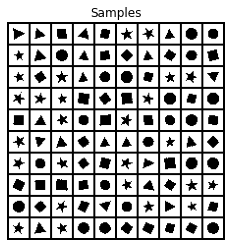

In [ ]:
show_samples(shapes_train[:100])

In [ ]:
num_classes = shapes_labels_train.max() + 1
num_classes

4

In [ ]:
shapes_labels_train

array([3, 3, 1, ..., 3, 2, 3])

In [ ]:
H, W, _ = shapes_train[0].shape
model = PixelCNN((1, H, W), labels=num_classes)
train_losses, test_losses, shapes_model = train_model(
    shapes_train, shapes_labels_train,
    shapes_test, shapes_labels_test,
    num_classes,
    model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 started


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


train loss: 0.1896843946784552, test_loss: 0.10993701964616776
epoch 1 started
train loss: 0.1439033451210136, test_loss: 0.08875402808189392
epoch 2 started
train loss: 0.1235492647395056, test_loss: 0.07653528451919556
epoch 3 started
train loss: 0.11053979612224124, test_loss: 0.0650516226887703
epoch 4 started
train loss: 0.1001453648864126, test_loss: 0.05308680236339569
epoch 5 started
train loss: 0.091529910900232, test_loss: 0.04421151056885719
epoch 6 started
train loss: 0.06811669802293181, test_loss: 0.0404420830309391
epoch 7 started
train loss: 0.058148064006119965, test_loss: 0.03943600505590439
epoch 8 started
train loss: 0.05054090448096395, test_loss: 0.03951141983270645
epoch 9 started
train loss: 0.044696809858083726, test_loss: 0.037724416702985764


In [ ]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.show()

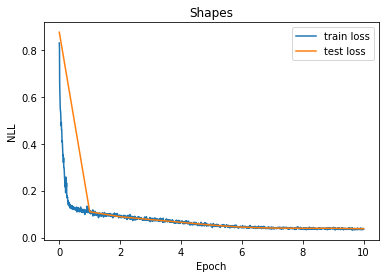

In [ ]:
show_train_plots(train_losses, test_losses, 'Shapes')

In [ ]:
labels = [0] * 25 + [1] * 25 + [2] * 25 + [3] * 25

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


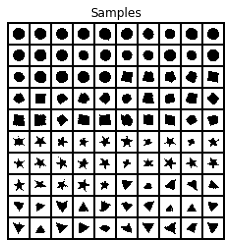

In [ ]:
samples = shapes_model.sample(100, torch.tensor(labels, dtype=torch.long).cuda())
show_samples(samples)

### Second dataset: MNIST (5 points)

In [ ]:
mnist_train, mnist_test, mnist_labels_train, mnist_labels_test = \
    load_data('./mnist.pkl', include_labels=True)

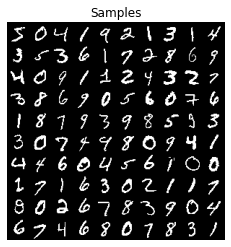

In [ ]:
show_samples(mnist_train[:100])

In [ ]:
num_classes = mnist_labels_train.max() + 1
num_classes

10

In [ ]:
H, W, _ = mnist_train[0].shape
model = PixelCNN((1, H, W), labels=num_classes)
train_losses, test_losses, mnist_model = train_model(
    mnist_train, mnist_labels_train,
    mnist_test, mnist_labels_test,
    num_classes,
    model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 started


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


train loss: 0.14381180392735288, test_loss: 0.08251471072435379
epoch 1 started
train loss: 0.08067559484392405, test_loss: 0.07796339690685272
epoch 2 started
train loss: 0.07732186752557754, test_loss: 0.07574249058961868
epoch 3 started
train loss: 0.0755134471654892, test_loss: 0.0742240622639656
epoch 4 started
train loss: 0.0742890158072114, test_loss: 0.07369489222764969
epoch 5 started
train loss: 0.07339647783339023, test_loss: 0.07358746230602264
epoch 6 started
train loss: 0.0727721659913659, test_loss: 0.07254450768232346
epoch 7 started
train loss: 0.07223672053217887, test_loss: 0.0719100832939148
epoch 8 started
train loss: 0.0718153338804841, test_loss: 0.07239717245101929
epoch 9 started
train loss: 0.07143586375564337, test_loss: 0.07219088077545166


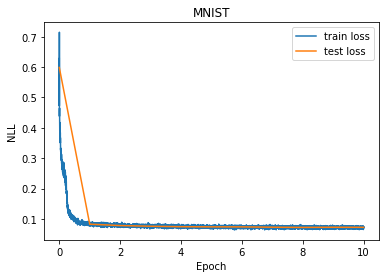

In [ ]:
show_train_plots(train_losses, test_losses, 'MNIST')

In [ ]:
labels = np.array(list(range(10)) * 10).reshape(10, 10).T

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


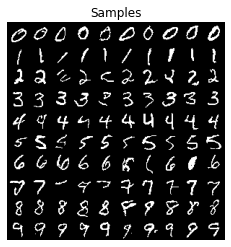

In [ ]:
samples = mnist_model.sample(100, torch.tensor(labels, dtype=torch.long).cuda())
show_samples(samples)